In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
from collections import Counter

In [2]:
anno_path = "../data/Anno_coarse"
eval_path = "../data/Eval"


bbox_path = os.path.join(anno_path, "list_bbox.txt")
landmarks_path = os.path.join(anno_path,"list_landmarks.txt")
category_cloth_path = os.path.join(anno_path, "list_category_cloth.txt")
category_img_path = os.path.join(anno_path, "list_category_img.txt")
attr_cloth_path = os.path.join(anno_path, "list_attr_cloth.txt")
attr_img_path = os.path.join(anno_path, "list_attr_img.txt")
eval_partition_path = os.path.join(eval_path, "list_eval_partition.txt")
img_folder = "../data/img"

In [3]:
def load_bbox_annotations(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Skips header (first 2 lines)
    num_images = int(lines[0].strip())
    columns = lines[1].strip().split()

    data = []
    for i in range(2, len(lines)):
        line = lines[i].strip().split()
        img_name = line[0]

        for j in range(1, len(line) - 4):
            img_name += ' ' + line[j]
        
        # Bounding box coordinates in last 4 elements
        bbox = [int(x) for x in line[-4:]]
        data.append([img_name] + bbox)
    
    bbox_df = pd.DataFrame(data, columns=['image_name', 'x_1', 'y_1', 'x_2', 'y_2'])
    return bbox_df

def load_category_cloth(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    num_categories = int(lines[0].strip())
    columns = lines[1].strip().split()
    
    data = []
    for i in range(2, len(lines)):
        line = lines[i].strip().split()
        category_name = line[0]
        # Consider image path whitespace
        for j in range(1, len(line) - 1):
            category_name += ' ' + line[j]
        
        category_type = int(line[-1])
        data.append([i-2, category_name, category_type])
    
    category_df = pd.DataFrame(data, columns=['category_id', 'category_name', 'category_type'])
    return category_df

def load_category_img(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    num_images = int(lines[0].strip())
    columns = lines[1].strip().split()
    
    data = []
    for i in range(2, len(lines)):
        line = lines[i].strip().split()
        img_name = line[0]
        # Consider image path whitespace
        for j in range(1, len(line) - 1):
            img_name += ' ' + line[j]
        
        category_label = int(line[-1])
        data.append([img_name, category_label])
    
    img_category_df = pd.DataFrame(data, columns=['image_name', 'category_id'])
    return img_category_df

def load_eval_partition(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    num_images = int(lines[0].strip())
    columns = lines[1].strip().split()
    
    data = []
    for i in range(2, len(lines)):
        line = lines[i].strip().split()
        img_name = line[0]
        # Consider image path whitespace
        for j in range(1, len(line) - 1):
            img_name += ' ' + line[j]
        
        eval_status = line[-1]
        data.append([img_name, eval_status])
    
    eval_df = pd.DataFrame(data, columns=['image_name', 'eval_status'])
    return eval_df

In [4]:
# Load category definitions
category_df = load_category_cloth(category_cloth_path)
print(f"Number of clothing categories: {len(category_df)}")
    
display(category_df.head())

Number of clothing categories: 50


,category_id,category_name,category_type
0,0,Anorak,1
1,1,Blazer,1
2,2,Blouse,1
3,3,Bomber,1
4,4,Button-Down,1


In [5]:
# load bounding box annotations
bbox_df = load_bbox_annotations(bbox_path)
print(f"\nBounding box annotations count: {len(bbox_df)}")

display(bbox_df.head())


Bounding box annotations count: 289222


,image_name,x_1,y_1,x_2,y_2
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,72,79,232,273
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,67,59,155,161
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65,65,156,200
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,51,62,167,182
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,46,88,166,262


In [6]:
# Load image category mappings
img_category_df = load_category_img(category_img_path)
print(f"\nImage-category mappings count: {len(img_category_df)}")

display(img_category_df.head())


Image-category mappings count: 289222


,image_name,category_id
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3


In [7]:
# Load evaluation partition
eval_df = load_eval_partition(eval_partition_path)
print(f"\nEvaluation partition entries: {len(eval_df)}")
    
display(eval_df.head())


Evaluation partition entries: 289222


,image_name,eval_status
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,train
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,train
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,val
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,train
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,test


In [8]:
partition_counts = eval_df['eval_status'].value_counts()
    
# Calculate percentages
partition_percentages = partition_counts / partition_counts.sum() * 100
    
partition_stats = pd.DataFrame({
    'Count': partition_counts,
    'Percentage (%)': partition_percentages.round(2)
})
    
display(partition_stats)

,Count,Percentage (%)
eval_status,,
train,209222,72.34
val,40000,13.83
test,40000,13.83


In [9]:
img_with_category = pd.merge(img_category_df, category_df, on='category_id')
    
# Category distribution
category_counts = img_with_category['category_name'].value_counts()
    
print(f"{len(category_counts)} total clothing categories.")
print(f"Top 15 most common clothing categories:")
display(category_counts.head(15))

46 total clothing categories.
Top 15 most common clothing categories:


category_name
Jumpsuit      72158
Top           36887
Bomber        24557
Skirt         19666
Tee           15429
Sweatpants    14773
Flannel       13311
Tank          13123
Jersey        10467
Turtleneck    10078
Blouse         7495
Shirtdress     7408
Jeggings       7076
Kaftan         6153
Sarong         5013
Name: count, dtype: int64

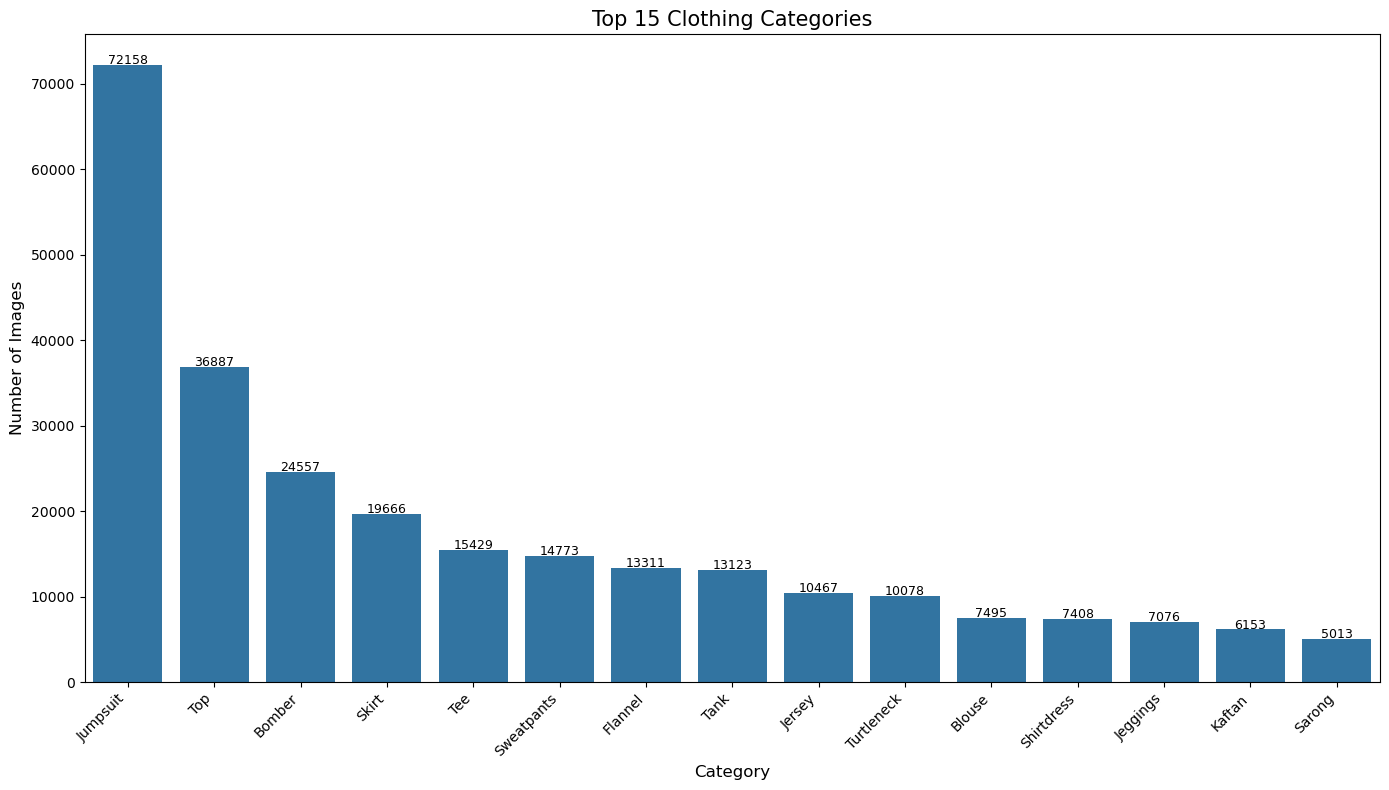

In [10]:
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=category_counts.head(15).index, y=category_counts.head(15).values)
plt.title('Top 15 Clothing Categories', fontsize=15)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')

for i, v in enumerate(category_counts.head(15)):
    ax.text(i, v + 100, f"{v}", ha='center', fontsize=9)
    
plt.tight_layout()
plt.show()

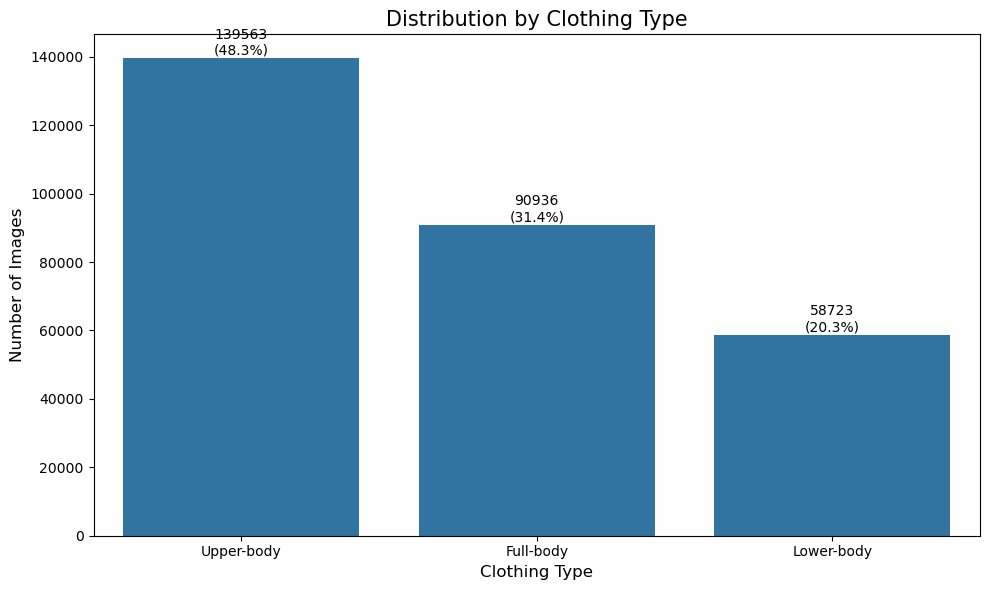

In [11]:
# Distribution by category type
type_mapping = {1: 'Upper-body', 2: 'Lower-body', 3: 'Full-body'}
category_type_counts = img_with_category['category_type'].map(type_mapping).value_counts()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=category_type_counts.index, y=category_type_counts.values)
plt.title('Distribution by Clothing Type', fontsize=15)
plt.xlabel('Clothing Type', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)

# Percentage labels
total = category_type_counts.sum()
for i, v in enumerate(category_type_counts):
    percentage = (v / total) * 100
    ax.text(i, v + 1000, f"{v}\n({percentage:.1f}%)", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [12]:
# Width and height of bounding boxes
bbox_df['width'] = bbox_df['x_2'] - bbox_df['x_1']
bbox_df['height'] = bbox_df['y_2'] - bbox_df['y_1']
bbox_df['area'] = bbox_df['width'] * bbox_df['height']

print("Bounding box statistics:")
display(bbox_df[['width', 'height', 'area']].describe())

Bounding box statistics:


,width,height,area
count,289222.000000,289222.000000,289222.000000
mean,141.636964,195.795652,29261.880303
std,58.024783,63.176140,18008.464918
min,2.000000,6.000000,154.000000
25%,99.000000,151.000000,15738.000000
50%,134.000000,198.000000,26106.000000
75%,173.000000,245.000000,37800.000000
max,299.000000,299.000000,89401.000000


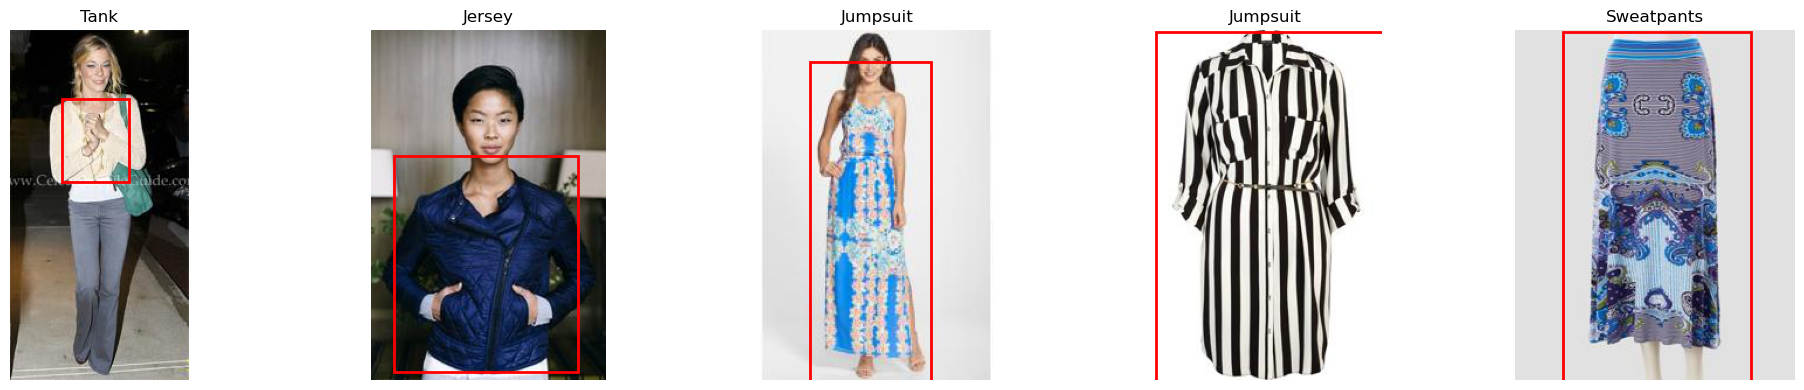

In [13]:
merged_data = pd.merge(bbox_df, img_category_df, on='image_name')
merged_data = pd.merge(merged_data, category_df, on='category_id')

samples = merged_data.sample(5)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, (_, row) in enumerate(samples.iterrows()):
    img_path = os.path.join("../data", row['image_name'])
    
    try:
        img = Image.open(img_path)
        
        axes[i].imshow(img)
        
        # Draw bounding box
        bbox = [row['x_1'], row['y_1'], row['x_2'], row['y_2']]
        rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                             fill=False, edgecolor='red', linewidth=2)
        axes[i].add_patch(rect)
        
        # Add category label
        axes[i].set_title(f"{row['category_name']}")
        axes[i].axis('off')
        
    except Exception as e:
        axes[i].text(0.5, 0.5, f"Error loading image:\n{str(e)}", 
                     horizontalalignment='center', verticalalignment='center',
                     transform=axes[i].transAxes)
        axes[i].axis('off')

plt.tight_layout()
plt.show()